In [46]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

In [26]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

# Generate random Clifford circuits as the training set

In [27]:
num_qubit = 4 # Number of qubits in the Clifford circuit

Stabilizers:  ['+IZII', '+YZXI', '-XZYY', '+XIYI']


In [28]:
def force_nonzero_expectation(clifford, print_bool=False):
    """Force the input Clifford operator to have a non-zero expectation value when measured in the all-Z basis.

    Args:
        clifford (Clifford): Clifford operator.
        print (bool, optional): Print the chosen random stabilizer.
    """
    # Create a QuantumCircuit from the Clifford operator
    qc_forced = clifford.to_circuit()

    # Get the stabilizers as a list of strings.
    # An example of a stabilizer string is "+XYZ"
    # with sign "+" and "Z" on qubit 1.
    stabilizers = clifford.to_dict()['stabilizer']
    for idx, stab in enumerate(stabilizers):
        # This method of forcing the Clifford operator to have
        # non-zero expectation in the all-Z basis only works
        # if the chosen stabilizer has no identity matrices.
        if 'I' not in stab:
            stabilizer = stab
            break
        # If we have tried every stabilizer, throw an exception
        if idx >= len(stabilizers)-1:
            raise UserWarning("All of the stabilizers have the identity matrix I!")
    if print_bool:
        print(f'Stabilizer: {stabilizer}')

    # Since the Clifford circuit has no classical register, add one
    # cr = ClassicalRegister(qc_forced.num_qubits)
    # qc_forced.add_register(cr)

    # Change the measurement basis of each qubit
    for qubit in range(0, qc_forced.num_qubits):
        op = stabilizer[qc_forced.num_qubits-qubit]
        if op == 'X':
            qc_forced.append(HGate(), [[qubit]]) # Convert to x-basis measurement
        elif op == 'Y':
            qc_forced.append(SdgGate(), [[qubit]])
            qc_forced.append(HGate(), [[qubit]])
        # # Measure qubit and store in classical bit
        # if measure and op != 'I':
        #     qc_forced.measure([qubit], [qubit])

    # Compute the expectation value based on the sign of the stabilizer
    if stabilizer[0] == '+':
        expectation = 1
    elif stabilizer[0] == '-':
        expectation = -1

    return qc_forced, expectation

def construct_random_clifford(num_qubit):
    rc = random_clifford(num_qubit)

    try:
        rc_forced, _ = force_nonzero_expectation(rc)
    except UserWarning:
        rc_forced = rc.to_circuit()

    rc_forced.measure_all()
    return rc_forced, rc.to_circuit()

In [29]:
rc_forced, rc = construct_random_clifford(num_qubit)
rc_forced.draw(fold=-1)

┌───┐                  ┌───┐┌───┐┌───┐                                 ░ ┌─┐         
   q_0: ──■───────┤ X ├───────■──────────┤ X ├┤ Y ├┤ H ├─────────────────────────────────░─┤M├─────────
        ┌─┴─┐┌───┐└─┬─┘┌───┐  │          └─┬─┘├───┤├───┤┌───┐┌───┐                       ░ └╥┘┌─┐      
   q_1: ┤ X ├┤ H ├──┼──┤ S ├──┼────────X───┼──┤ X ├┤ H ├┤ X ├┤ H ├───────────────────────░──╫─┤M├──────
        └───┘└───┘  │  └───┘┌─┴─┐┌───┐ │   │  └─┬─┘└───┘└─┬─┘├───┤┌───┐┌───┐┌─────┐┌───┐ ░  ║ └╥┘┌─┐   
   q_2: ────────────┼───────┤ X ├┤ H ├─┼───■────┼─────────■──┤ H ├┤ S ├┤ X ├┤ Sdg ├┤ H ├─░──╫──╫─┤M├───
        ┌───┐┌───┐  │  ┌───┐└───┘└───┘ │        │  ┌───┐     └───┘└───┘└───┘└─────┘└───┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ S ├┤ H ├──■──┤ H ├───────────X────────■──┤ Y ├─────────────────────────────────░──╫──╫──╫─┤M├
        └───┘└───┘     └───┘                       └───┘                                 ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                            0  1  2  3

In [30]:
def cal_z_exp(counts):
        """
        Compute all sigma_z expectations values.

        Parameters
        ----------
        counts : dict
            Dictionary of state labels (keys, e.g. '000', '001')

        Returns
        -------
        z_exp : list of float
            sigma_z expectation values, where len(z_exp) is the number of qubits
        """
        shots = sum(list(counts.values()))
        num_qubits = len(list(counts.keys())[0])
        count_pos_z = np.zeros(num_qubits) # counts of positive z
        # Convert all keys into arrays
        for key, val in counts.items():
            count_pos_z += val * np.array(list(key), dtype=int)
        count_neg_z = np.ones(num_qubits) * shots - count_pos_z # counts of negative z
        z_exp = (count_pos_z - count_neg_z) / shots
        return z_exp

def calc_imbalance(single_z_dataset, even_qubits, odd_qubits):
        """Calculate the charge imbalance from the single-Z expectation values.

        Args:
            single_z_dataset (list[list[float]]): Single-Z expectation values. First index is qubits, second index is expectation value at each time
            even_qubits (list[int]): Indices of even qubits
            odd_qubits (list[int]): Indices of odd qubits

        Returns:
            imbalance list[float]: Charge imbalance
        """
        num_qubit = len(even_qubits)+len(odd_qubits)
        num_steps = len(single_z_dataset)
        imbalance = np.zeros(num_steps)
        for step in range(num_steps):
            ib = 0
            for qubit in range(num_qubit):
                if qubit in even_qubits:
                    ib += single_z_dataset[step][qubit]
                elif qubit in odd_qubits:
                    ib -= single_z_dataset[step][qubit]
                else:
                    print(f'Warning: The index {i} was not in even_qubits or odd_qubits')
            imbalance[step] = ib / num_qubit
        return imbalance

In [31]:
def generate_data(save_path: str, n_entries_per_file: int):
        entries = []

        for i in tqdm_notebook(range(n_entries_per_file)):
            circuit, _ = construct_random_clifford(num_qubit)
            circuit = transpile(circuit, backend_noisy, optimization_level=3)

            job_ideal = execute(circuit, **run_config_ideal)
            job_noisy = execute(circuit, **run_config_noisy)

            counts_ideal = job_ideal.result().get_counts()
            counts_noisy = job_noisy.result().get_counts()

            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)

            graph_data = circuit_to_graph_data_json(
                circuit=circuit,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[noisy_exp_val.tolist()],
                circuit_depth=circuit.depth()
            )
            entries.append(entry.to_dict())

        path = f"{save_path}/random_clifford.json"
        with open(path, "w") as f:
            # pprint(entries)
            json.dump(entries, f)

In [33]:
# generate_data('./data/haoran_mbl/rc_train', 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

# Sanity check on the all-z expectation value of the generated random Cliffords

In [80]:
def cal_all_z_exp(counts):
    """
    Compute the Z^N expectation value, where N is the number of bits in each bitstring

    Parameters
    ----------
    counts : dict
        Dictionary of state labels (keys, e.g. '000', '001') and
        counts (ints, e.g. 900, 100, 24 that add up to the total shots 1024)

    Returns
    -------
    all_z_exp : float
    """
    shots = sum(list(counts.values()))
    all_z_exp = 0
    for key, value in counts.items():
        num_ones = key.count('1')
        sign = (-1) ** (num_ones) # Sign of the term in 'key' depends on the number of 0's, e.g. '11' is +, '110' is -
        all_z_exp += sign * value
    all_z_exp = all_z_exp / shots
    return all_z_exp

out = []
for _ in tqdm_notebook(range(5000)):
    circuit, _ = construct_random_clifford(num_qubit)
    try:
        circuit = transpile(circuit, backend_noisy, optimization_level=3)
    except:
        circuit, _ = construct_random_clifford(num_qubit)
        circuit = transpile(circuit, backend_noisy, optimization_level=3)
    job_ideal = execute(circuit, **run_config_ideal)
    counts_ideal = job_ideal.result().get_counts()
    ideal_exp_val = cal_all_z_exp(counts_ideal)
    out.append(ideal_exp_val)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [95]:
out = out2

In [97]:
out = np.array(out)

In [98]:
out[(out < 0.95) & (out > -0.95)] = 0

Text(0.5, 1.0, '5000 "random" clifford all-Z expectation')

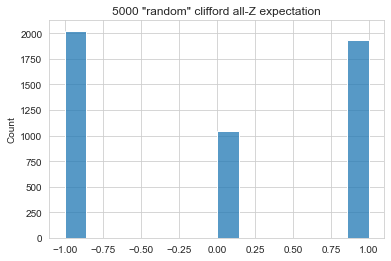

In [104]:
sns.histplot(out)
plt.title('5000 "random" clifford all-Z expectation')

# Training

In [36]:
train_paths = [
    './data/haoran_mbl/rc_train/random_clifford.json',
]
val_paths = [
     './data/mbd_datasets/val/step_5.json',
     './data/mbd_datasets/val/step_4.json',
     './data/mbd_datasets/val/step_3.json',
     './data/mbd_datasets/val/step_2.json',
     './data/mbd_datasets/val/step_1.json',
     './data/mbd_datasets/val/step_0.json',
     './data/mbd_datasets/val/step_6.json'
]

In [37]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[1755, 22], edge_index=[2, 3923], edge_attr=[2168, 3], y=[32, 1, 4], observable=[32, 0], circuit_depth=[32, 1], noisy_0=[32, 1, 4], batch=[1755], ptr=[33])


In [38]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()

        self.transformer1 = TransformerConv(
            num_node_features, hidden_channels,
            heads=3,
            dropout=0.1
        )
        self.pooling1 = ASAPooling(hidden_channels * 3, 0.5)

        self.transformer2 = TransformerConv(
            hidden_channels * 3, hidden_channels,
            heads=2,
            dropout=0.1
        )
        self.pooling2 = ASAPooling(hidden_channels * 2, 0.5)

        self.body_seq = torch.nn.Sequential(
            Linear(hidden_channels * 2 + 5, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 4)
        )

    def forward(self,
                exp_value, observable,
                circuit_depth, nodes,
                edge_index, batch):
        graph = self.transformer1(nodes, edge_index)
        graph, edge_index, _, batch, _ = self.pooling1(
            graph, edge_index, batch=batch
        )

        graph = self.transformer2(graph, edge_index)
        graph, edge_index, _, batch, _ = self.pooling2(
            graph, edge_index, batch=batch
        )

        graph = global_mean_pool(graph, batch)

        merge = torch.cat((
            graph,
            torch.squeeze(exp_value, 1),
            circuit_depth
        ), dim=1)

        return self.body_seq(merge)


model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15
)
criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

In [39]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 00100: reducing learning rate of group 0 to 1.0000e-04.


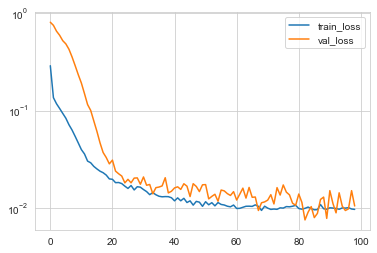

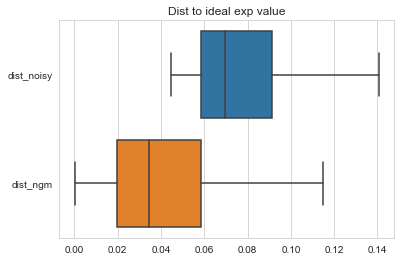

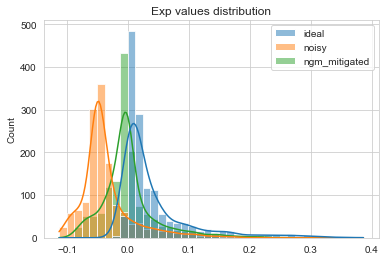

In [48]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })

df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

# Test on charge imbalance on newly generated MBL circuits

In [49]:
model.eval()


ExpValCircuitGraphModel(
  (transformer1): TransformerConv(22, 15, heads=3)
  (pooling1): ASAPooling(45, ratio=0.5)
  (transformer2): TransformerConv(45, 15, heads=2)
  (pooling2): ASAPooling(30, ratio=0.5)
  (body_seq): Sequential(
    (0): Linear(35, 15, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(15, 4, bias=True)
  )
)

In [51]:
def construct_mbl_circuit(num_qubit, disorder, theta, steps):
    """Construct the circuit for Floquet dynamics of an MBL circuit.

    Args:
        num_spins (int): Number of spins. Must be even.
        W (float): Disorder strength up to np.pi.
        theta (float): Interaction strength up to np.pi.
        steps (int): Number of steps.
    """
    qc = QuantumCircuit(num_qubit)

    # Hard domain wall initial state
    # Qubits 0 to num_qubit/2 - 1 are up, and qubits num_qubit/2 to num_qubit - 1 are down
    for qubit_idx in range(num_qubit):
        if qubit_idx % 2 == 1:
            qc.x(qubit_idx)

    ## Floquet evolution
    for step in range(steps):
        # Interactions between even layers
        for even_qubit in range(0, num_qubit, 2):
            qc.append(CZGate(), (even_qubit, even_qubit+1))
            qc.append(U3Gate(theta, 0, -np.pi), [even_qubit])
            qc.append(U3Gate(theta, 0, -np.pi), [even_qubit+1])
        # Interactions between odd layers
        for odd_qubit in range(1, num_qubit-1, 2):
            qc.append(CZGate(), (odd_qubit, odd_qubit+1))
            qc.append(U3Gate(theta, 0, -np.pi), [odd_qubit])
            qc.append(U3Gate(theta, 0, -np.pi), [odd_qubit+1])
        # Apply RZ disorder
        for q in range(num_qubit):
            qc.append(PhaseGate(disorder[q]), [q])

    # Measure Z^{\otimes num_qubit}, or the all-Z operator from which all Z, ZZ, ... operators can be computed
    qc.measure_all()

    return qc

def generate_disorder(n_qubits, disorder_strength = np.pi, seed=0):
    """Generate disorder

    Args:
        n_qubits (int): Number of qubits
        disorder_strength (float, optional): Scales disorder strength from min/max of -pi/pi. Defaults to pi.

    Returns:
        List[float]: List of angles in single-qubit phase gates that correspond to disorders
    """
    random.seed(seed)
    disorder = [np.random.uniform(-1 * disorder_strength, disorder_strength) for _ in range(n_qubits)]
    return disorder

In [53]:
## Set the physics parameters
## No need to change W and theta
## Change `num_spins` for system size, `max_steps` to evolve deeper (2Q gate depth of 2 per step), and
## `seed` for different disorders for when we do the disorder-averaged time-dependent charge imbalance
num_spins = 4 # Number of spins. Must be even.
W = 0.8 * np.pi # Disorder strength up to np.pi
theta = 0.05 * np.pi # Interaction strength up to np.pi
max_steps = 10
seed = 2 # Seed for the randomly generated array of disorder potentials

disorders = generate_disorder(num_spins, W, seed=seed)

qc_list = []
for steps in range(max_steps):
    qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

# Take a look at the circuit to make sure it's got the correct brickwork style
s = {'fold': -1}
qc_list[3].draw(**s)

┌───────────────┐┌─────────────┐                                  ┌───────────────┐┌─────────────┐                                  ┌───────────────┐┌─────────────┐                                ░ ┌─┐         
   q_0: ──────■─┤ U3(π/20,0,-π) ├┤ P(-0.83356) ├────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(-0.83356) ├────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(-0.83356) ├────────────────────────────────░─┤M├─────────
        ┌───┐ │ ├───────────────┤└─────────────┘┌───────────────┐┌───────────┐  │ ├───────────────┤└─────────────┘┌───────────────┐┌───────────┐  │ ├───────────────┤└─────────────┘┌───────────────┐┌───────────┐  ░ └╥┘┌─┐      
   q_1: ┤ X ├─■─┤ U3(π/20,0,-π) ├───────■───────┤ U3(π/20,0,-π) ├┤ P(1.7082) ├──■─┤ U3(π/20,0,-π) ├───────■───────┤ U3(π/20,0,-π) ├┤ P(1.7082) ├──■─┤ U3(π/20,0,-π) ├───────■───────┤ U3(π/20,0,-π) ├┤ P(1.7082) ├──░──╫─┤M├──────
        └───┘   ├───────────────┤       │       ├───────────────┤├───────────┴┐   ├───────────────┤       │       ├───────────────┤├───────────┴┐   ├───────────────┤       │       ├───────────────┤├───────────┴┐ ░  ║ └╥┘┌─┐   
   q_2: ──────■─┤ U3(π/20,0,-π) ├───────■───────┤ U3(π/20,0,-π) ├┤ P(-2.0388) ├─■─┤ U3(π/20,0,-π) ├───────■───────┤ U3(π/20,0,-π) ├┤ P(-2.0388) ├─■─┤ U3(π/20,0,-π) ├───────■───────┤ U3(π/20,0,-π) ├┤ P(-2.0388) ├─░──╫──╫─┤M├───
        ┌───┐ │ ├───────────────┤┌─────────────┐└───────────────┘└────────────┘ │ ├───────────────┤┌─────────────┐└───────────────┘└────────────┘ │ ├───────────────┤┌─────────────┐└───────────────┘└────────────┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─■─┤ U3(π/20,0,-π) ├┤ P(-0.92002) ├────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(-0.92002) ├────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(-0.92002) ├────────────────────────────────░──╫──╫──╫─┤M├
        └───┘   └───────────────┘└─────────────┘                                  └───────────────┘└─────────────┘                                  └───────────────┘└─────────────┘                                ░  ║  ║  ║ └╥┘
meas: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                                                       0  1  2  3

In [55]:
## Now we need to average over many disorders
num_disorders = 30

even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated = []

for disorder_realization in tqdm_notebook(range(num_disorders)):
    disorders = generate_disorder(num_spins, W, seed=disorder_realization)

    qc_list = []
    for steps in range(max_steps):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated = []


    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        graph_data = circuit_to_graph_data_json(
            circuit=transpiled_qc_list[i],
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[
                noisy_exp_val.tolist()
            ],
            circuit_depth=transpiled_qc_list[i].depth()
        ).to_pyg_data()

        # print(entry.batch)
        mitigated_exp_val = model(entry.noisy_0,
                            entry.observable,
                            entry.circuit_depth,
                            entry.x,
                            entry.edge_index,
                            entry.batch).tolist()[0]

        exp_Z_mitigated.append(mitigated_exp_val)

    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)


    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated.append(imbalance_mitigated)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average = np.mean(imbalance_all_mitigated, axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

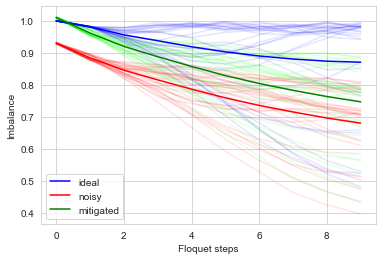

In [56]:
## Plot
for disorder_realization in range(num_disorders):
    plt.plot(imbalance_all_ideal[disorder_realization], color=(0.0, 0.0, 1.0, 0.1))
    plt.plot(imbalance_all_noisy[disorder_realization], color=(1.0, 0.0, 0.0, 0.1))
    plt.plot(imbalance_all_mitigated[disorder_realization], color=(0.0, 1.0, 0.0, 0.1))

plt.plot(imbalance_ideal_average, color='blue', label="ideal")
plt.plot(imbalance_noisy_average, color='red', label="noisy")
plt.plot(imbalance_mitigated_average, color='green', label="mitigated")

plt.xlabel('Floquet steps')
plt.ylabel('Imbalance')
plt.legend()
plt.show()